Sample SPO Triples:

Subject: Scrooge | Predicate: be | Object: partners
Subject: Scrooge | Predicate: be | Object: executor
Subject: Scrooge | Predicate: paint | Object: name
Subject: heat | Predicate: have | Object: influence
Subject: children | Predicate: ask | Object: man
Subject: Scrooge | Predicate: have | Object: fire
Subject: Nephew | Predicate: return | Object: uncle
Subject: nephew | Predicate: leave | Object: room
Subject: workhouses | Predicate: demand | Object: Scrooge
Subject: Scrooge | Predicate: resume | Object: labours

Stats:
Sentences processed: 1526
Total SPO triples extracted: 113


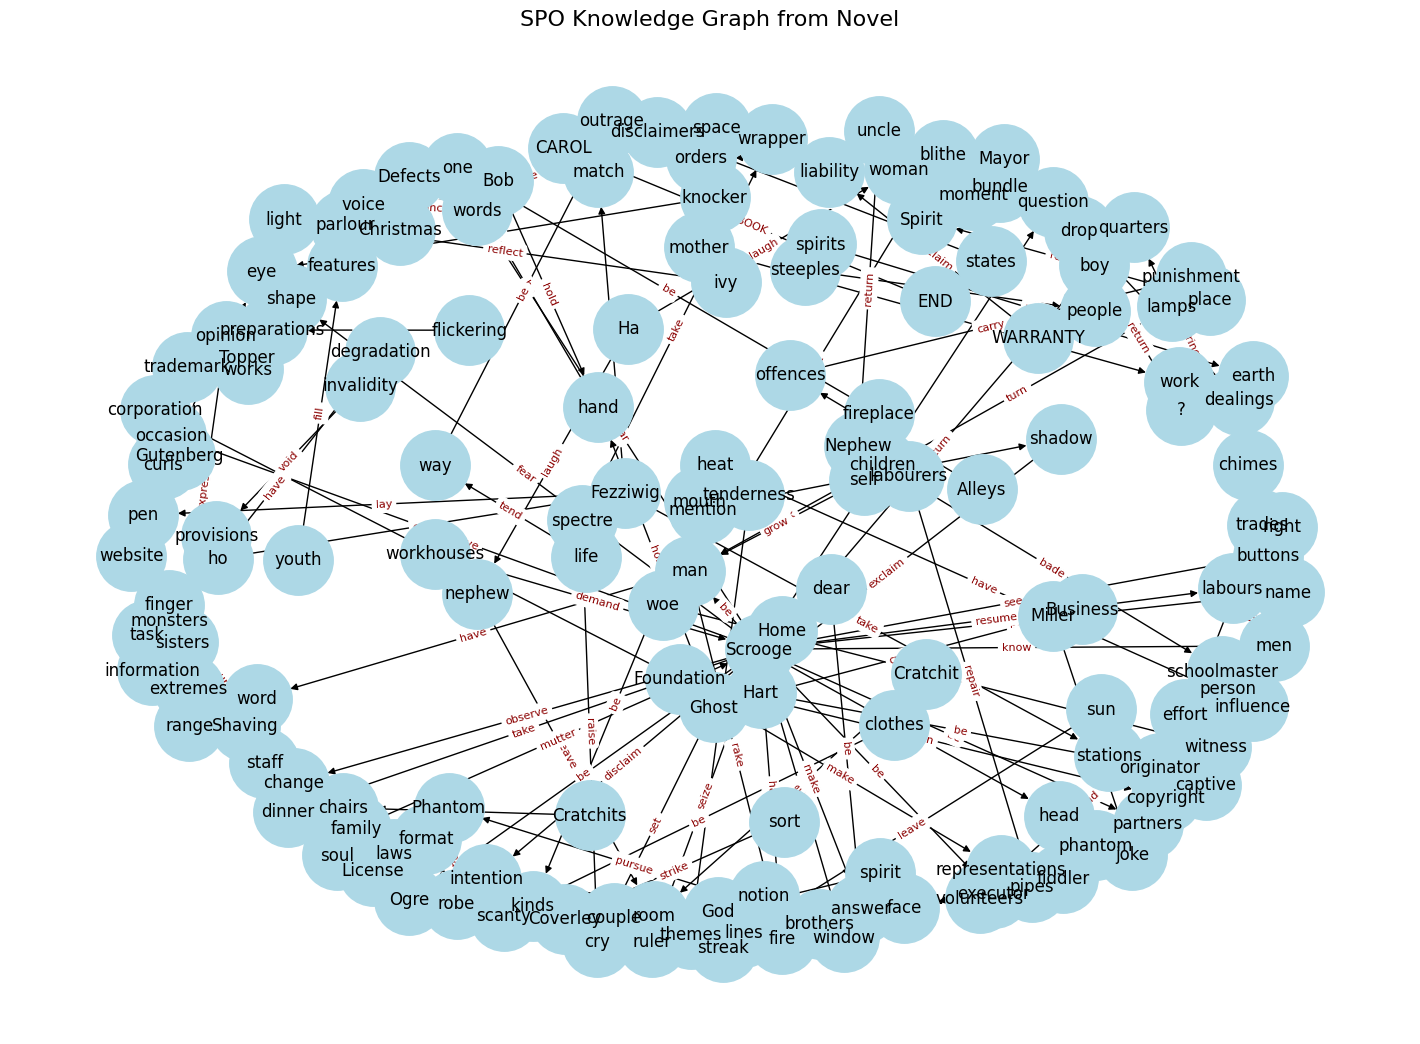

In [2]:
# SPO Triple Extraction from a Novel with Filtering and Graph Visualization

import spacy
import re
import networkx as nx
import matplotlib.pyplot as plt

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Load the text file (modify path if needed)
with open("novel.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Clean Project Gutenberg header
start_idx = text.find("STAVE I")
if start_idx != -1:
    text = text[start_idx:]

# Normalize whitespace
text = re.sub(r'\s+', ' ', text)
text = re.sub(r'_+', '', text)

# Sentence tokenization
doc = nlp(text)
sentences = [sent.text.strip() for sent in doc.sents if len(sent.text.split()) >= 5]

# Optional pronoun filtering
EXCLUDE_PRONOUNS = False
PRONOUNS = {"i", "he", "she", "it", "they", "we", "you"}

def is_valid_subject(token):
    return (token.pos_ in {"NOUN", "PROPN"} and (not EXCLUDE_PRONOUNS or token.text.lower() not in PRONOUNS))

def is_valid_object(token):
    return (token.pos_ in {"NOUN", "PROPN"} and (not EXCLUDE_PRONOUNS or token.text.lower() not in PRONOUNS))

# Extract all SPO triples from a sentence
def extract_spo(sentence):
    doc = nlp(sentence)
    triples = []
    for token in doc:
        if token.dep_ == "ROOT":
            subject = ""
            obj = ""
            # Find subject(s)
            for child in token.children:
                if "subj" in child.dep_ and is_valid_subject(child):
                    subject = child.text
            # Find object(s)
            for child in token.children:
                if ("obj" in child.dep_ or child.dep_ == "attr") and is_valid_object(child):
                    obj = child.text
            # Save triple if complete
            if subject and token.lemma_ and obj:
                triples.append((subject, token.lemma_, obj))
    return triples

# Extract triples from all sentences
spo_triples = []
for sent in sentences:
    triples = extract_spo(sent)
    spo_triples.extend(triples)

# Print sample output
print("Sample SPO Triples:\n")
for s, p, o in spo_triples[:10]:
    print(f"Subject: {s} | Predicate: {p} | Object: {o}")

print("\nStats:")
print(f"Sentences processed: {len(sentences)}")
print(f"Total SPO triples extracted: {len(spo_triples)}")

# --- Visualize Knowledge Graph ---
G = nx.DiGraph()
for subj, pred, obj in spo_triples:
    G.add_node(subj)
    G.add_node(obj)
    G.add_edge(subj, obj, label=pred)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2500, font_size=12, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred', font_size=8)
plt.title("SPO Knowledge Graph from Novel", fontsize=16)
plt.axis('off')
plt.show()